- Transfer learning, only retrained MLP
- Data Augmentation
- Train/test -> 

In [1]:
from keras.applications import ResNet50, MobileNetV2
from keras import models
from keras import layers
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
#from keras.applications.mobilenet import preprocess_input
#keras.applications.resnet_v2.ResNet152V2

Using TensorFlow backend.
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sol/.virtualenvs/maskrc

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import csv

from sklearn.model_selection import train_test_split
from glob import glob
from keras.preprocessing import image

### Settings

In [3]:
ROOT_DIR = os.path.abspath("../../")
DS_DIR = os.path.join(ROOT_DIR, "Datasets/awe_cvledb_aug_100/")

CLASSES = 116  # Amount of people in the dataset 
TRAIN_PERCENTAGE = 75
#SAMPLE_PER_PERSON = 0
#TRAIN_SIZE = round(SAMPLE_PER_PERSON*(TRAIN_PERCENTAGE/100))

#EPHOCS = 15

IMAGE_SIZE = 224  #224 ResNet50    #160 MobileNetV2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

## Build model

In [4]:
#Load the ResNet50 model
res_net = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
res_net.trainable = False

W1016 17:04:09.199522 139666232559424 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1016 17:04:09.211637 139666232559424 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1016 17:04:09.216642 139666232559424 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1016 17:04:09.234073 139666232559424 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is dep

In [5]:
res_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Complete  the model
- To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
- Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [6]:
# Complete  the model
global_average_layer = layers.GlobalAveragePooling2D(name='AvgPooling2D')
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

prediction_layer = layers.Dense(CLASSES, activation='softmax', name='predictions')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

model = models.Sequential([
  res_net,
  global_average_layer,
  prediction_layer
])

In [7]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=optimizers.RMSprop(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Save the model
#model.save('small_last4.h5')

W1016 17:04:20.057330 139666232559424 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
AvgPooling2D (GlobalAverageP (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 116)               237684    
Total params: 23,825,396
Trainable params: 237,684
Non-trainable params: 23,587,712
_________________________________________________________________


## Load data

In [9]:
# get X and y list
X_train_list = []
#X_test_list = []
y_train_list = []
#y_test_list = []
for (dirpath, u_dirnames, filenames) in os.walk(DS_DIR):
    dirnames = sorted(u_dirnames)
    for i in range(0,len(dirnames)):
        FILE_DIR = os.path.join(DS_DIR, str(dirnames[i]))
        FILE_DIR = os.path.join(FILE_DIR, "da")
        files = glob(FILE_DIR+'/*.png') 
        
        #if len(files) < SAMPLE_PER_PERSON:
        SAMPLE_PER_PERSON = len(files)
        
        #TRAIN_SIZE = round(SAMPLE_PER_PERSON*(TRAIN_PERCENTAGE/100))
        
        for j in range (0,SAMPLE_PER_PERSON):            
            image_class = int(str(dirnames[i]))-1
            img = image.load_img(files[j], target_size=(IMAGE_SIZE, IMAGE_SIZE))
            img_data = image.img_to_array(img)
            img_data = preprocess_input(img_data)
            X_train_list.append(img_data)
            y_train_list.append(image_class)   
        #for j in range (TRAIN_SIZE,SAMPLE_PER_PERSON):            
            #image_class = int(str(dirnames[i]))-1
            #img = image.load_img(files[j], target_size=(IMAGE_SIZE, IMAGE_SIZE))
            #img_data = image.img_to_array(img)
            #img_data = preprocess_input(img_data)
            #X_test_list.append(img_data)
            #y_test_list.append(image_class)                   
    break

In [10]:
#X = np.array(X_list)
#y = np.array(y_list)
#X.shape, y.shape, len(y)

In [11]:
# Normalize data
#X = X /255.0


In [12]:
#Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [13]:
X_train = np.array(X_train_list)
#X_test = np.array(X_test_list)
y_train = np.array(y_train_list)
#y_test = np.array(y_test_list)

#Normalize
#X_train = X_train/255.0
#X_test = X_test/255.0

#X_train.shape, X_test.shape, len(y_train), len(y_test)
X_train.shape, len(y_train)

((12073, 224, 224, 3), 12073)

In [14]:
X_train[0]

array([[[-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        ...,
        [  33.060997,   51.221   ,   65.32    ],
        [  33.060997,   51.221   ,   65.32    ],
        [  33.060997,   51.221   ,   65.32    ]],

       [[-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        ...,
        [  33.060997,   51.221   ,   65.32    ],
        [  33.060997,   51.221   ,   65.32    ],
        [  33.060997,   51.221   ,   65.32    ]],

       [[-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        ...,
        [  33.060997,   51.221   ,   65.32    ],
        [  33.060997,   51.221   ,   65.32    ],
        [  33.060997,   51.221   ,   65.32    ]],

       ...,

       [[-103.939   , -116.779   , -123.68    ],
        [-1

In [15]:
hist_y = np.zeros((CLASSES + 1))
for i in range (0, len(y_train)):
    x = y_train[i]
    hist_y[x] += 1
sum(hist_y)

12073.0

In [16]:
hist_y

array([100., 100.,  99., 100., 100., 100., 100., 100.,  99., 100., 100.,
       100., 100.,  99., 100., 100.,  99.,  99.,  99.,  99., 100., 100.,
       100.,  96.,  98., 100.,  99., 100., 100.,  99., 100., 100.,  98.,
       100.,  99., 100., 100., 100., 100., 100., 100., 100., 100.,  99.,
        99., 100.,  97., 100.,  98., 100., 100.,  99.,  99., 100.,  99.,
        99., 100., 100., 100.,  99.,  99.,  99., 100., 100., 100., 100.,
       100.,  99., 100., 100.,  98.,  98.,  99., 100.,  99.,  99.,  99.,
       100., 100.,  99., 100., 100.,  99., 100.,  99., 100., 100., 100.,
       100.,  98., 100.,  99., 100., 100., 100., 100.,  99.,  97.,  99.,
       100., 139., 164., 128., 112., 128., 186., 100., 107., 108., 125.,
       120., 142., 144., 119., 175., 128.,   0.])

## Train model

In [18]:
#history = model.fit(X_train, y_train, validation_split=0.25, epochs=50, batch_size=64)
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.7716 - acc: 0.9038
Epoch 2/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.7079 - acc: 0.9139
Epoch 3/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.6467 - acc: 0.9240
Epoch 4/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.5890 - acc: 0.9336
Epoch 5/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.5428 - acc: 0.9411
Epoch 6/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.4992 - acc: 0.9436
Epoch 7/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.4639 - acc: 0.9491
Epoch 8/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.4286 - acc: 0.9555
Epoch 9/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.3976 - acc: 0.9610
Epoch 10/10
12073/12073 [==============================] - 50s 4ms/step - loss: 0.3708 - acc: 0.9620

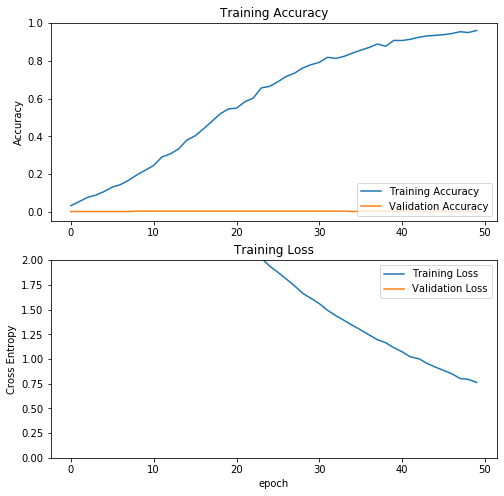

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
# 15/10/19 50 epochs - CVLEDB + AWE - ResNet50 - 75% data to train
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

401/401 [==============================] - 3s 7ms/step
Test accuracy: 0.229426434138172


In [53]:
# 15/10/19 50 epochs - CVLEDB + AWE - ResNet50 - 75% data to train 
# and cross validation 4 folds
loss: 0.7627 - acc: 0.9601 - val_loss: 15.9996 - val_acc: 0.0022

401/401 [==============================] - 3s 7ms/step
Test accuracy: 0.14962593517138476


In [17]:
# 10 epochs - CVLEDB + AMI Augmented - ResNet50 - 95% data to train
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

928/928 [==============================] - 5s 5ms/step
Test accuracy: 0.1853448275862069


In [16]:
# 20 epochs - CVLEDB Augmented - ResNet50 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

992/992 [==============================] - 5s 5ms/step
Test accuracy: 0.3548387096774194


In [20]:
# 30 epochs - CVLEDB Augmented - ResNet50 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

992/992 [==============================] - 5s 5ms/step
Test accuracy: 0.4092741935483871


In [26]:
# 50 epochs - CVLEDB Augmented - ResNet50 - 95% data to train
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

192/192 [==============================] - 1s 7ms/step
Test accuracy: 0.4322916666666667


In [15]:
# 20 epochs - AWE Augmented
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2000/2000 [==============================] - 3s 2ms/step
Test accuracy: 0.01


In [17]:
# 20 epochs - CVLEDB Augmented
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

992/992 [==============================] - 2s 2ms/step
Test accuracy: 0.0625


In [20]:
# 20 epochs - CVLEDB Augmented - MobileNet
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

992/992 [==============================] - 2s 2ms/step
Test accuracy: 0.20161290322580644


In [20]:
# 30 epochs - CVLEDB Augmented - MobileNet
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

992/992 [==============================] - 2s 2ms/step
Test accuracy: 0.2399193548387097


In [27]:
# 90 epochs - CVLEDB Augmented - MobileNet
# 95% data to train
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

192/192 [==============================] - 1s 4ms/step
Test accuracy: 0.203125


## Use model as feature extractor

In [19]:
from keras.models import Model


In [20]:
model_extractor = Model(input=model.input, output=model.get_layer('AvgPooling2D').output)
model_extractor.summary()

/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("re..., outputs=Tensor("Av...)`
  """Entry point for launching an IPython kernel.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
AvgPooling2D (GlobalAverageP (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
ROOT_DIR = os.path.abspath("../../")
DS_DIR = os.path.join(ROOT_DIR, "Datasets/ami/")

In [22]:
feature_list = []
for (dirpath, u_dirnames, filenames) in os.walk(DS_DIR):
    dirnames = sorted(u_dirnames)
    for i in range(0,len(dirnames)):
        FILE_DIR = os.path.join(DS_DIR, str(dirnames[i]))
        #FILE_DIR = os.path.join(FILE_DIR, "da")
        files = glob(FILE_DIR+'/*.jpg') 
        for j in range (0,len(files)):            
            image_class = np.array([int(str(dirnames[i]))])
            img = image.load_img(files[j], target_size=(IMAGE_SIZE, IMAGE_SIZE))
            img_data = image.img_to_array(img)
            img_data = preprocess_input(img_data)
            img_data = np.expand_dims(img_data, axis=0)
            fc2_features = model_extractor.predict(img_data)
            #vgg16_feature = model.predict(img_data)
            image_vector = np.array(fc2_features)            
            #image_vector = getVector()                       
            feature_np = np.concatenate((image_class, image_vector[0]), axis=0)                                  
            feature_list.append(feature_np.flatten())            
    break

#print(len(vgg16_feature_list))
#print(len(vgg16_feature_np))
head = []
head.append('class')
for i in range(1, len(feature_np)):
    head.append('v'+str(i))

head_np = []
head_np.append(head)
#print(head_np)

In [26]:
print(head_np)

[['class', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v60', 'v61', 'v62', 'v63', 'v64', 'v65', 'v66', 'v67', 'v68', 'v69', 'v70', 'v71', 'v72', 'v73', 'v74', 'v75', 'v76', 'v77', 'v78', 'v79', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v90', 'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v120', 'v121', 'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v130', 'v131', 'v132', 'v133', 'v134', 'v135', 'v136', 'v137', '

In [23]:
with open('resnet50_trained_on_cvledb_awe_augmented100_tested_ami.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(head_np)
    writer.writerows(feature_list)
csvFile.close()